<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/3_Skin_models_mcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

---



In [1]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.models.abod import ABOD
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn

##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Visualization
from matplotlib.pyplot import subplot

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

     |████████████████████████████████| 112kB 12.7MB/s 
  Created wheel for pyod: filename=pyod-0.8.8-cp37-none-any.whl size=116967 sha256=17920eacbca5ed29a0581662743ea28398c2f87b09e74e9ac3efe37bed03a2c8
  Stored in directory: /root/.cache/pip/wheels/54/dd/36/a12fa930455b7c38902f2dbf737175421ad30436e47ac5b24d
Successfully built pyod
     |████████████████████████████████| 153kB 14.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for isotree: filename=isotree-0.2.7.post1-cp37-cp37m-linux_x86_64.whl size=5864107 sha256=d165d40c6d386a25e8e04b005d594621bccd3e047c1e0b31fe44ea6b665e440a
  Stored in directory: /root/.cache/pip/wheels/53/7c/1a/ef01c0d0033a38793dd91a66b2d48b546efbf5f9545d6f97e5
Successfully built isotree


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Functions & Data Import

---



In [2]:
#Functions 

scaler = RobustScaler()

#Train-test splits
def train_test_split(full_dataframe, train_size, test_size, random_state = 1):
    train_set = full_dataframe.sample(random_state = random_state, n = train_size)
    train_X = train_set.drop('original.label', axis = 1) 
    train_y = train_set['original.label']
    
    test_set = full_dataframe.drop(train_set.index).sample(random_state = random_state, n = test_size)
    test_X = test_set.drop('original.label', axis = 1)
    test_y = test_set['original.label']
    return train_X, test_X, train_y, test_y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions 
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
    print(recall_score(test_y,pred))
    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))
    print("\n", model_name, "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

    #Plots confusion matrix
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    #Plots ROC Curve
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #Plots PR Curve
    prec, recall, _ = precision_recall_curve(test_y, score,
                                         pos_label = clf.labels_[1])
    prec_ave = average_precision_score(test_y, score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision= prec_ave, estimator_name= model_name).plot()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred, target_names=['Normal', 'Anomaly']))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))

    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Anomaly','Predicted Normal'],
                yticklabels = ['Actual Anomaly','Actual Normal'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

 #   prec, recall, _ = precision_recall_curve(test_y, score,
  #                                       pos_label = clf.labels_[1])
  #  prec_ave = average_precision_score(test_y, score)
  #  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision= prec_ave, estimator_name= model_name).plot()

In [3]:
#Load data
skin_control = pd.read_csv("skin_benchmark_0903.csv") #Control group
skin_924 = pd.read_csv("skin_benchmark_0924.csv") #Scattered
skin_941 = pd.read_csv("skin_benchmark_0941.csv") #Least Clustered
skin_942 = pd.read_csv("skin_benchmark_0942.csv") #Most clustered

skin_control = skin_control.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
skin_924 = skin_924.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
skin_941 = skin_941.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
skin_942 = skin_942.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)

In [4]:
#Encoding normal as 0 anomalies as 1
skin_control['original.label'] = skin_control['original.label'].apply(lambda z: 0 if(z == 2) else 1)
skin_924['original.label'] = skin_924['original.label'].apply(lambda z: 0 if(z == 2) else 1)
skin_941['original.label'] = skin_941['original.label'].apply(lambda z: 0 if(z == 2) else 1)
skin_942['original.label'] = skin_942['original.label'].apply(lambda z: 0 if(z == 2) else 1)

# Exploratory Analysis

In [ ]:
skin_control.head()

In [ ]:
subplot(2, 1, 2)
plt.hist(skin_control['R'], bins=30)
plt.xlabel('R')
plt.ylabel('Count')

subplot(2, 2, 1)
plt.hist(skin_control['G'], bins=30)
plt.xlabel('G')
plt.ylabel('Count')

subplot(2, 2, 2)
plt.hist(skin_control['B'], bins=30)
plt.xlabel('B')
plt.ylabel('Count')

plt.show()

# BM_903 : control group

In [6]:
#Train-test split
train_X, test_X, train_y, test_y = train_test_split(skin_control, 4200, 1800, 42)

In [7]:
#Standardization
scaler = RobustScaler()
train_X_st = scaler.fit_transform(train_X)
test_X_st = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
train_X_st_resampled, train_y_st_resampled= ADASYN(ratio = 'minority').fit_sample(train_X_st, train_y_st)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

## IForest

---



On Training Data:
IForest ROC:0.2925, precision @ rank n:0.3186

On Test Data:
IForest ROC:0.4639, precision @ rank n:0.0
0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.96      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.96      0.97      1800


 IForest Matthews Correlation Coefficient -0.016779116102190593

 IForest f1-score 0.0

 IForest Balanced Accuracy 0.48764044943820223


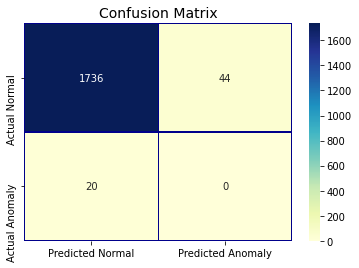

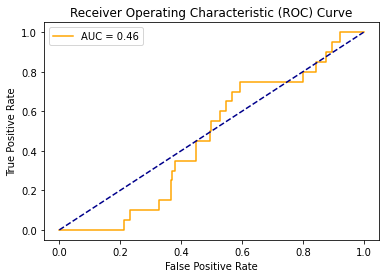

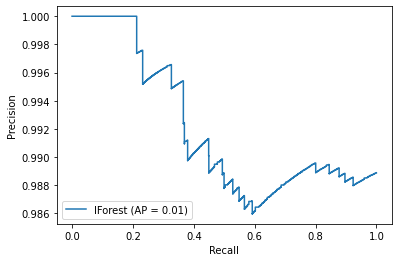

In [ ]:
#Oversampled
#Not standardized
get_prediction(IForest(n_estimators = 100, max_samples = 1024, contamination = 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.9003, precision @ rank n:0.0

On Test Data:
IForest ROC:0.839, precision @ rank n:0.0
0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.90      0.94      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.89      1800
   macro avg       0.49      0.45      0.47      1800
weighted avg       0.98      0.89      0.93      1800


 IForest Matthews Correlation Coefficient -0.035442215323457205

 IForest f1-score 0.0

 IForest Balanced Accuracy 0.4491573033707865


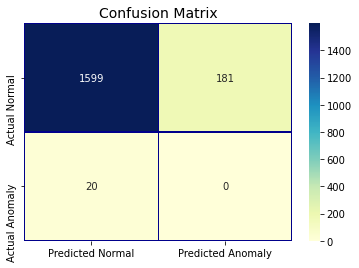

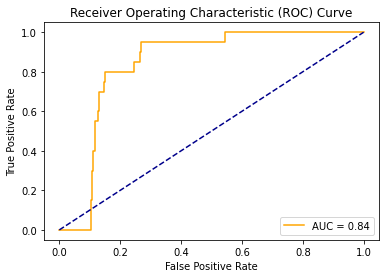

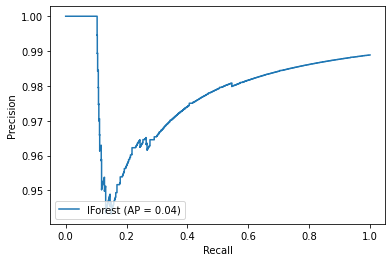

In [ ]:
#Not oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 2048, contamination = 0.1), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.68      0.81      1780
     Anomaly       0.03      0.90      0.06        20

    accuracy                           0.68      1800
   macro avg       0.51      0.79      0.43      1800
weighted avg       0.99      0.68      0.80      1800


 SciForest  Confusion Matrix: 
 [[1206  574]
 [   2   18]]

 SciForest Matthews Correlation Coefficient 0.12885574636698227

 SciForest f1-score 0.05882352941176471


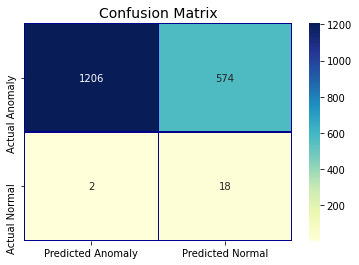

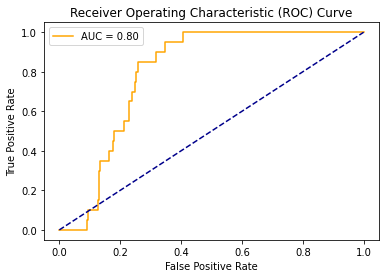

In [ ]:
#Oversampled
#Not Stnadardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1,
                                   prob_pick_pooled_gain=0, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.86      0.92      1780
     Anomaly       0.01      0.15      0.02        20

    accuracy                           0.85      1800
   macro avg       0.50      0.50      0.47      1800
weighted avg       0.98      0.85      0.91      1800


 SciForest  Confusion Matrix: 
 [[1526  254]
 [  17    3]]

 SciForest Matthews Correlation Coefficient 0.0021882595086627796

 SciForest f1-score 0.021660649819494587


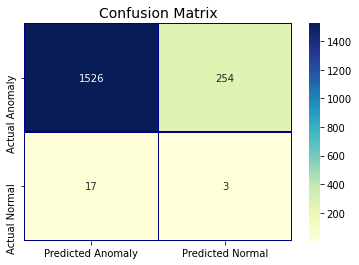

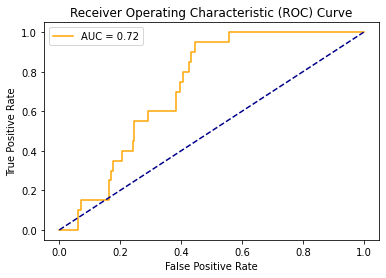

In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 85, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.4509, precision @ rank n:0.504

On Test Data:
OCSVM ROC:0.0567, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.97      1800


 OCSVM Matthews Correlation Coefficient -0.013799996964001

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.49157303370786515


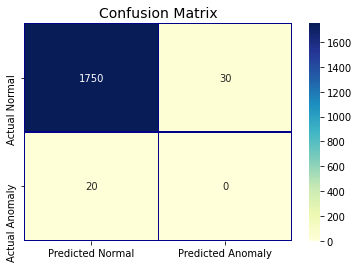

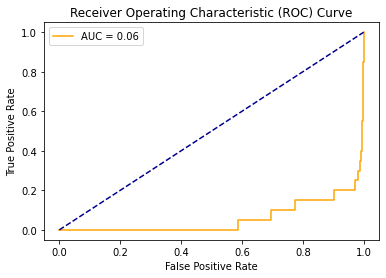

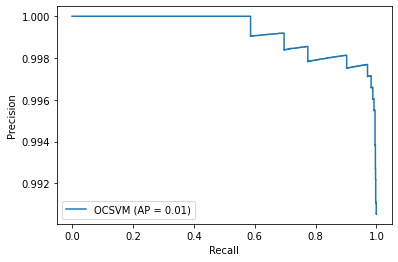

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.03, contamination= 0.01, kernel = 'rbf'),
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.6456, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.4115, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.99      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.99      0.98      1800


 OCSVM Matthews Correlation Coefficient 0.0

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


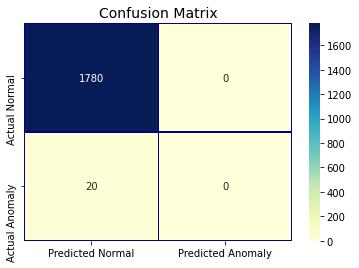

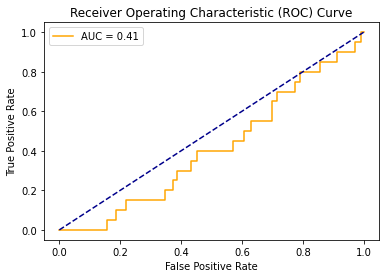

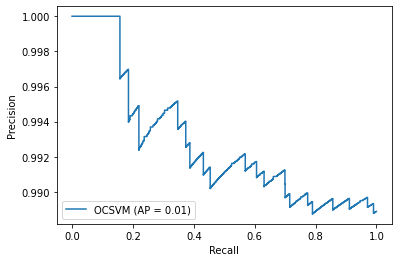

In [ ]:
#Not oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.03, contamination= 0.01, kernel = 'rbf'),
               train_X_st, test_X_st, train_y_st, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.3535, precision @ rank n:0.4124

On Test Data:
LOF ROC:0.8444, precision @ rank n:0.0
0.8

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.88      0.93      1780
     Anomaly       0.07      0.80      0.13        20

    accuracy                           0.88      1800
   macro avg       0.53      0.84      0.53      1800
weighted avg       0.99      0.88      0.92      1800


 LOF Matthews Correlation Coefficient 0.210620646505225

 LOF f1-score 0.12549019607843137

 LOF Balanced Accuracy 0.8384831460674158


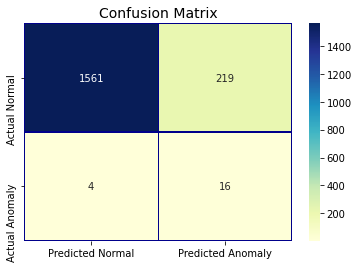

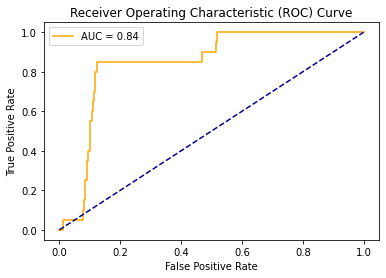

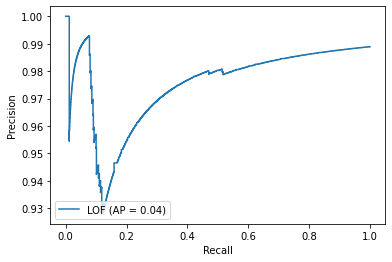

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.5029, precision @ rank n:0.0

On Test Data:
LOF ROC:0.4805, precision @ rank n:0.0
0.05

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.92      0.95      1780
     Anomaly       0.01      0.05      0.01        20

    accuracy                           0.91      1800
   macro avg       0.50      0.49      0.48      1800
weighted avg       0.98      0.91      0.94      1800


 LOF Matthews Correlation Coefficient -0.011177441960200494

 LOF f1-score 0.012422360248447206

 LOF Balanced Accuracy 0.4856741573033708


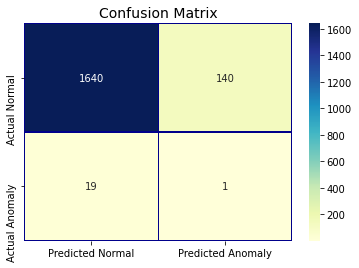

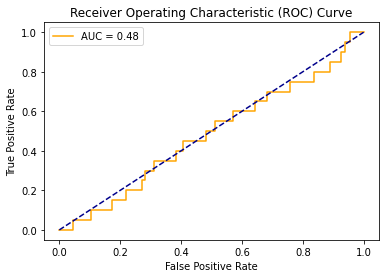

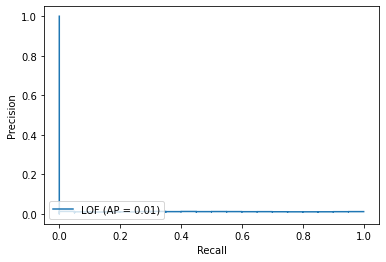

In [ ]:
#Not oversampled
#Standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st, test_X_st, train_y_st, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.3805, precision @ rank n:0.4107

On Test Data:
CBLOF ROC:0.7537, precision @ rank n:0.0
0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.98      0.98      1800


 CBLOF Matthews Correlation Coefficient -0.009716984634549205

 CBLOF f1-score 0.0

 CBLOF Balanced Accuracy 0.4957865168539326


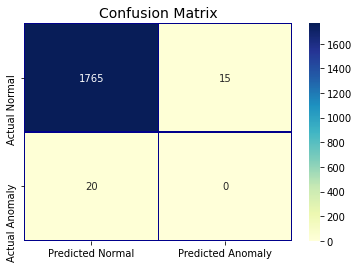

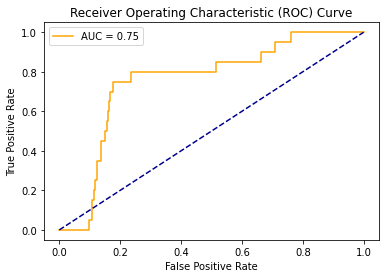

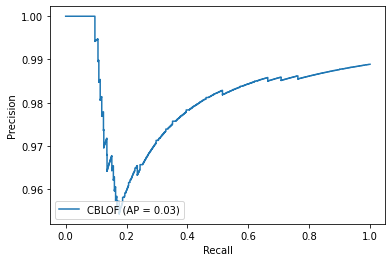

In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 30, alpha= 0.9, beta= 25, random_state=42), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9598, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.898, precision @ rank n:0.0
0.2

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.94      0.97      1780
     Anomaly       0.04      0.20      0.06        20

    accuracy                           0.93      1800
   macro avg       0.51      0.57      0.51      1800
weighted avg       0.98      0.93      0.96      1800


 CBLOF Matthews Correlation Coefficient 0.06300937183073962

 CBLOF f1-score 0.06299212598425195

 CBLOF Balanced Accuracy 0.571067415730337


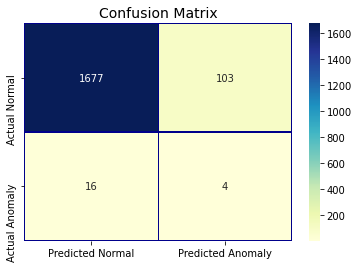

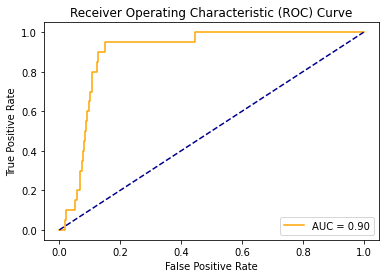

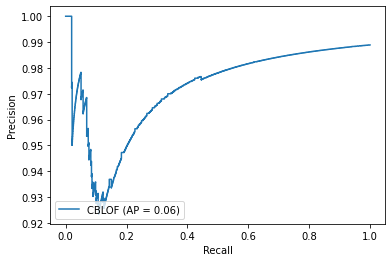

In [ ]:
#Not oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 30, alpha= 0.9, beta= 25, random_state=42), 
               train_X_st, test_X_st, train_y_st, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.2196, precision @ rank n:0.2889

On Test Data:
KNN ROC:0.8196, precision @ rank n:0.0
0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.98      1800


 KNN Matthews Correlation Coefficient -0.01332453781132611

 KNN f1-score 0.0

 KNN Balanced Accuracy 0.49213483146067416


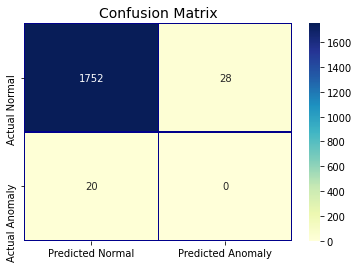

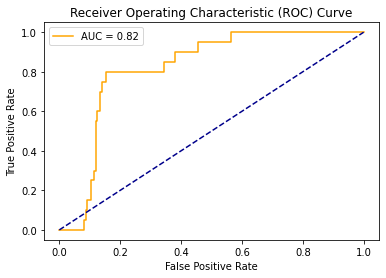

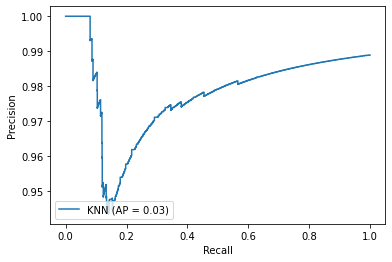

In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.9372, precision @ rank n:0.0

On Test Data:
KNN ROC:0.8759, precision @ rank n:0.0
0.85

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.83      0.90      1780
     Anomaly       0.05      0.85      0.10        20

    accuracy                           0.83      1800
   macro avg       0.53      0.84      0.50      1800
weighted avg       0.99      0.83      0.90      1800


 KNN Matthews Correlation Coefficient 0.18485730644123688

 KNN f1-score 0.09883720930232558

 KNN Balanced Accuracy 0.8387640449438203


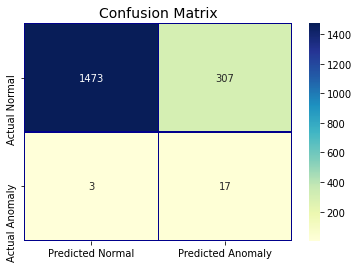

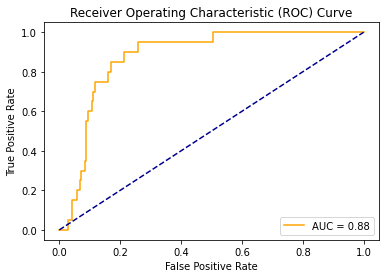

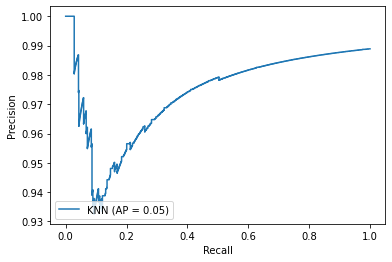

In [ ]:
#Not oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.1), 
               train_X_st, test_X_st, train_y_st, test_y, 'KNN')

## ABOD
---

In [ ]:
#Oversampled
#Standardized
get_prediction(ABOD(contamination=0.01, n_neighbors=210, method= 'fast'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'ABOD')

On Training Data:
ABOD ROC:0.0182, precision @ rank n:0.0646

On Test Data:
ABOD ROC:0.6608, precision @ rank n:0.05
0.1

 ABOD  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.93      0.96      1780
     Anomaly       0.02      0.10      0.03        20

    accuracy                           0.92      1800
   macro avg       0.50      0.52      0.49      1800
weighted avg       0.98      0.92      0.95      1800


 ABOD Matthews Correlation Coefficient 0.013021025036556676

 ABOD f1-score 0.027777777777777776

 ABOD Balanced Accuracy 0.5157303370786517


In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.49      1800
weighted avg       0.98      0.98      0.98      1800


 Matthews Correlation Coefficient -0.010038470867858362

 f1-score 0.0

 Balanced Accuracy 0.49550561797752807


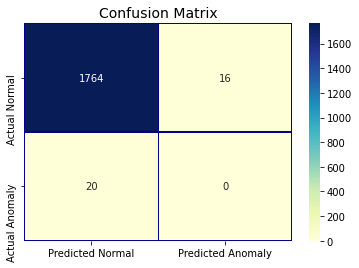

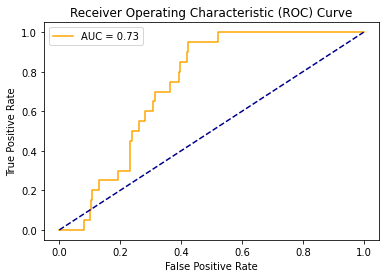

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X_st)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# BM_924 : scattered

In [ ]:
#Train-test set
train_X, test_X, train_y, test_y = train_test_split(skin_924, 4200, 1800, 42)

In [ ]:
#Standardization
scaler = RobustScaler()
train_X_st = scaler.fit_transform(train_X)
test_X_st = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
train_X_st_resampled, train_y_st_resampled= ADASYN(ratio = 'minority').fit_sample(train_X_st, train_y_st)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.01
Percentage Test Set Contamination:      0.01


## IForest

---



On Training Data:
IForest ROC:0.1769, precision @ rank n:0.2785

On Test Data:
IForest ROC:0.651, precision @ rank n:0.0
0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.98      1800


 IForest Matthews Correlation Coefficient -0.01373476072383882

 IForest f1-score 0.0

 IForest Balanced Accuracy 0.49074074074074076


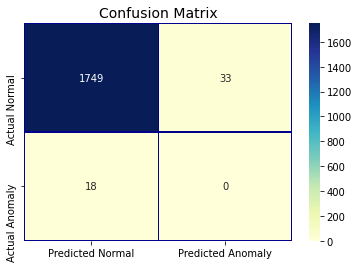

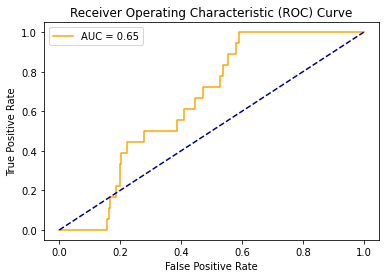

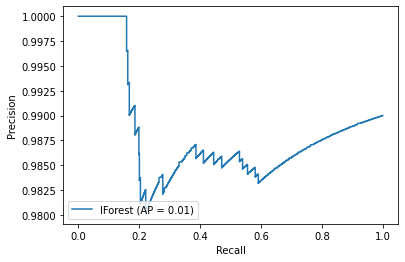

In [ ]:
#Oversampled
#Not standardized
get_prediction(IForest(n_estimators = 100, max_samples = 1024, contamination = 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.9093, precision @ rank n:0.0

On Test Data:
IForest ROC:0.8604, precision @ rank n:0.0
0.05555555555555555

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.89      0.94      1782
     Anomaly       0.01      0.06      0.01        18

    accuracy                           0.88      1800
   macro avg       0.50      0.47      0.47      1800
weighted avg       0.98      0.88      0.93      1800


 IForest Matthews Correlation Coefficient -0.017207723462585436

 IForest f1-score 0.009345794392523364

 IForest Balanced Accuracy 0.4730639730639731


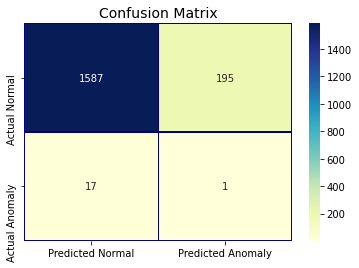

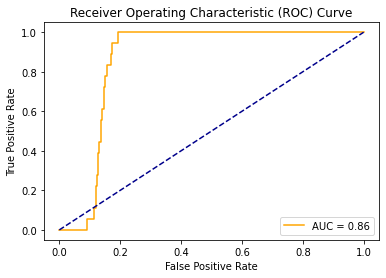

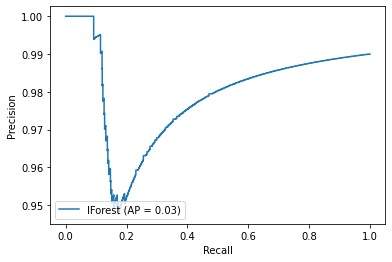

In [ ]:
#Not oversampled
#Not standardized
get_prediction(IForest(n_estimators = 50, max_samples = 2048, contamination = 0.1), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.75      0.85      1782
     Anomaly       0.04      1.00      0.07        18

    accuracy                           0.75      1800
   macro avg       0.52      0.87      0.46      1800
weighted avg       0.99      0.75      0.85      1800


 SciForest  Confusion Matrix: 
 [[1329  453]
 [   0   18]]

 SciForest Matthews Correlation Coefficient 0.16882409861236314

 SciForest f1-score 0.07361963190184048


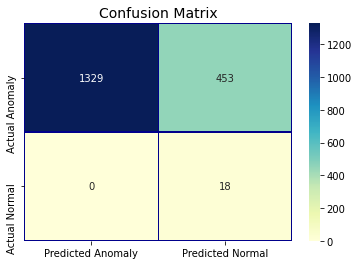

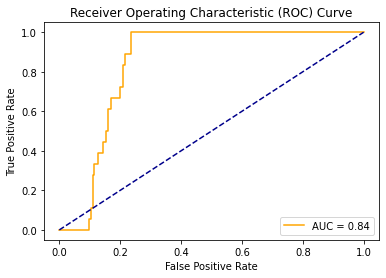

In [ ]:
#Oversampled
#Not standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.89      0.94      1782
     Anomaly       0.03      0.33      0.05        18

    accuracy                           0.88      1800
   macro avg       0.51      0.61      0.50      1800
weighted avg       0.98      0.88      0.93      1800


 SciForest  Confusion Matrix: 
 [[1585  197]
 [  12    6]]

 SciForest Matthews Correlation Coefficient 0.07007650480129579

 SciForest f1-score 0.05429864253393664


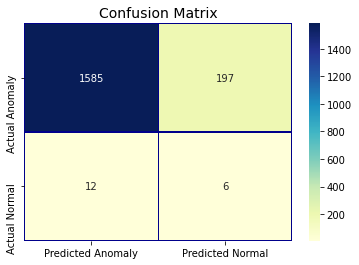

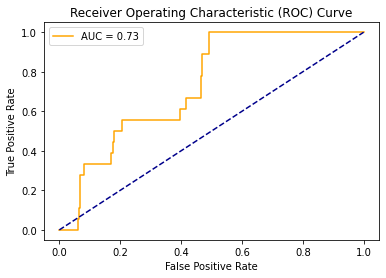

In [ ]:
#Not oversampled
#Not standardized
get_prediction_iso(IsolationForest(sample_size = 85, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.316, precision @ rank n:0.3946

On Test Data:
OCSVM ROC:0.052, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.99      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.99      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.006715191366878169

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.49775533108866443


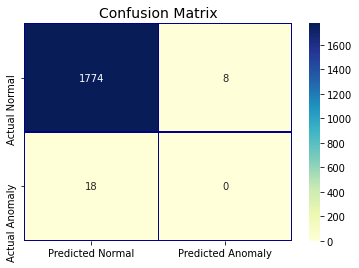

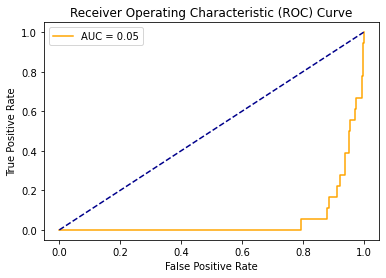

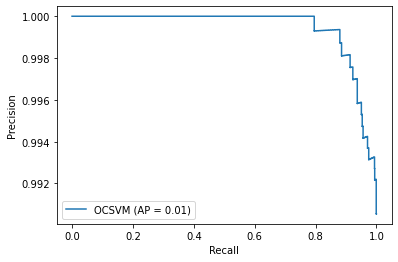

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.922, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.8201, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.99      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.99      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.00530438671169578

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.49859708193041524


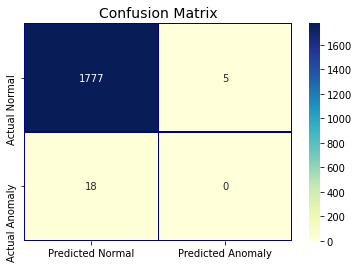

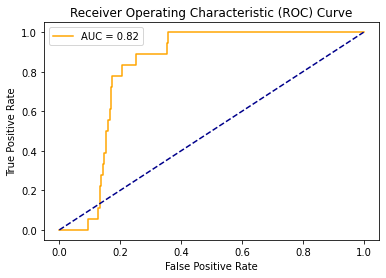

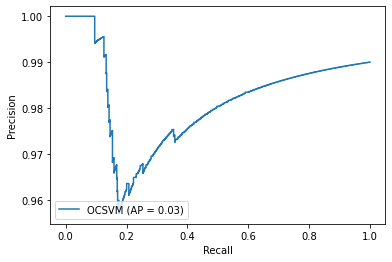

In [ ]:
#Not oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st, test_X_st, train_y_st, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.3361, precision @ rank n:0.3856

On Test Data:
LOF ROC:0.7575, precision @ rank n:0.1667
0.6666666666666666

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.76      0.87      1782
     Anomaly       0.03      0.67      0.05        18

    accuracy                           0.76      1800
   macro avg       0.51      0.72      0.46      1800
weighted avg       0.99      0.76      0.86      1800


 LOF Matthews Correlation Coefficient 0.10061630939261643

 LOF f1-score 0.05345211581291759

 LOF Balanced Accuracy 0.7157687991021324


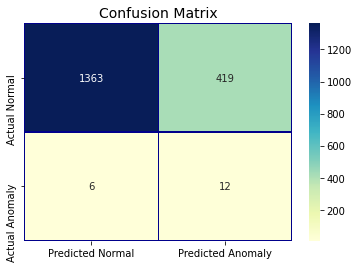

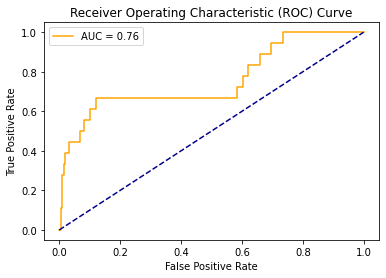

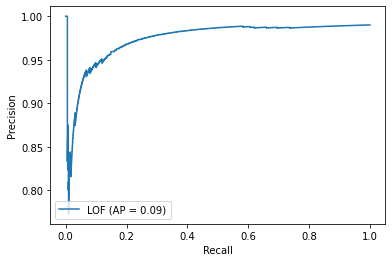

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.6842, precision @ rank n:0.0

On Test Data:
LOF ROC:0.5022, precision @ rank n:0.0
0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.91      0.95      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.90      1800
   macro avg       0.49      0.45      0.47      1800
weighted avg       0.98      0.90      0.94      1800


 LOF Matthews Correlation Coefficient -0.032140123846220475

 LOF f1-score 0.0

 LOF Balanced Accuracy 0.45314253647586983


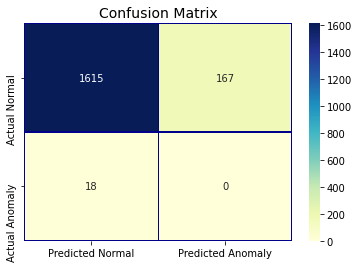

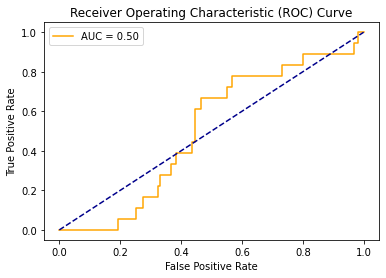

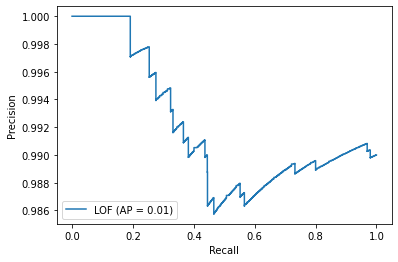

In [ ]:
#Not oversampled
#Standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st, test_X_st, train_y_st, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.3048, precision @ rank n:0.3652

On Test Data:
CBLOF ROC:0.8031, precision @ rank n:0.0
0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.98      0.98      1800


 CBLOF Matthews Correlation Coefficient -0.008572190278692382

 CBLOF f1-score 0.0

 CBLOF Balanced Accuracy 0.4963524130190797


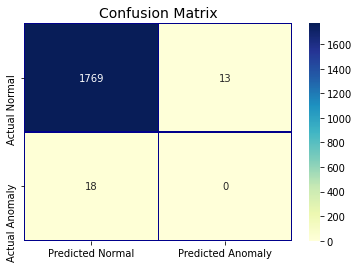

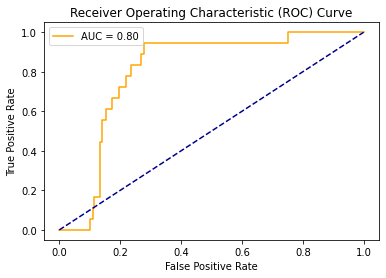

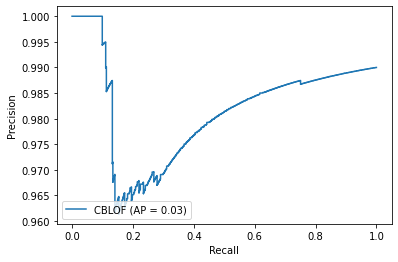

In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 30, alpha= 0.9, beta= 20, random_state=42), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.8985, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.8324, precision @ rank n:0.0
0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.94      0.96      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.93      1800
   macro avg       0.49      0.47      0.48      1800
weighted avg       0.98      0.93      0.95      1800


 CBLOF Matthews Correlation Coefficient -0.025764935958258624

 CBLOF f1-score 0.0

 CBLOF Balanced Accuracy 0.46885521885521886


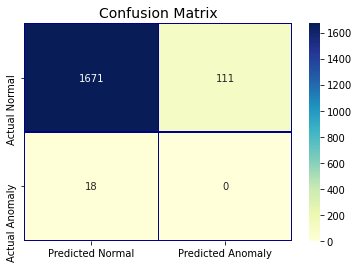

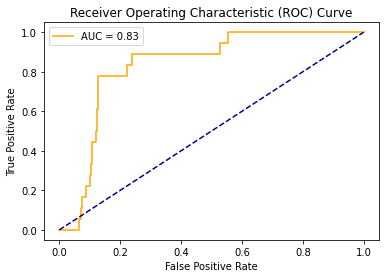

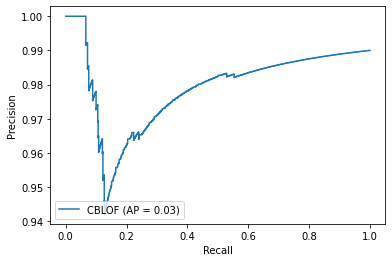

In [ ]:
#Not oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 30, alpha= 0.9, beta= 25, random_state=42), 
               train_X_st, test_X_st, train_y_st, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.2035, precision @ rank n:0.2807

On Test Data:
KNN ROC:0.8294, precision @ rank n:0.0
0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      1782
     Anomaly       0.00      0.00      0.00        18

    accuracy                           0.96      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.96      0.97      1800


 KNN Matthews Correlation Coefficient -0.016093484986175587

 KNN f1-score 0.0

 KNN Balanced Accuracy 0.48737373737373735


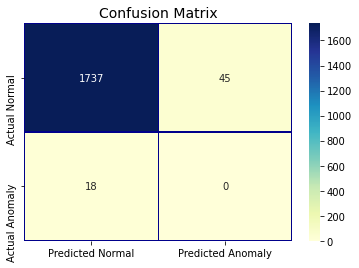

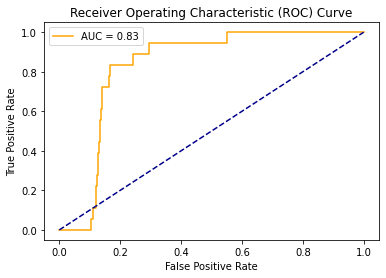

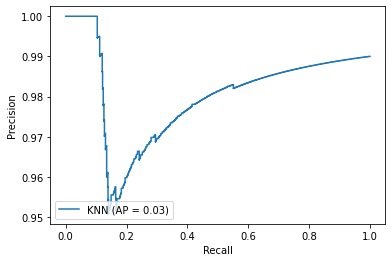

In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.903, precision @ rank n:0.0

On Test Data:
KNN ROC:0.8231, precision @ rank n:0.0
0.5

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.84      0.91      1782
     Anomaly       0.03      0.50      0.06        18

    accuracy                           0.83      1800
   macro avg       0.51      0.67      0.48      1800
weighted avg       0.98      0.83      0.90      1800


 KNN Matthews Correlation Coefficient 0.08935610062722407

 KNN f1-score 0.056249999999999994

 KNN Balanced Accuracy 0.6677890011223344


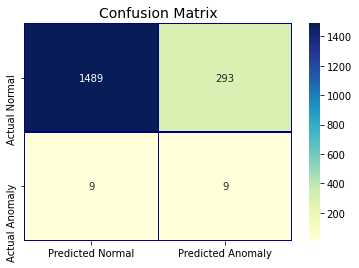

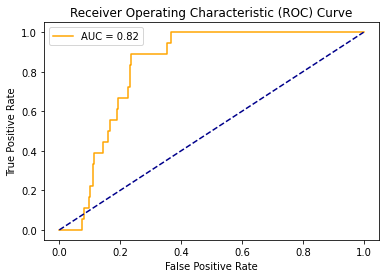

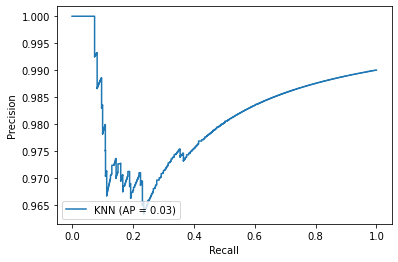

In [ ]:
#Not oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.1), 
               train_X_st, test_X_st, train_y_st, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [ ]:
get_prediction(ABOD(contamination=0.01, n_neighbors=210, method= 'fast'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'ABOD')

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X_st)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.63      0.77      1782
     Anomaly       0.01      0.33      0.02        18

    accuracy                           0.63      1800
   macro avg       0.50      0.48      0.40      1800
weighted avg       0.98      0.63      0.76      1800


 Matthews Correlation Coefficient -0.006838311576610246

 f1-score 0.01772525849335303

 Balanced Accuracy 0.48344556677890005


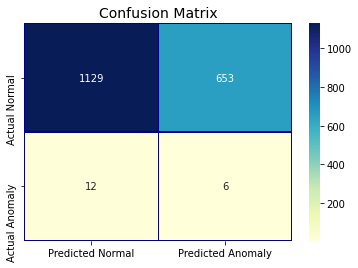

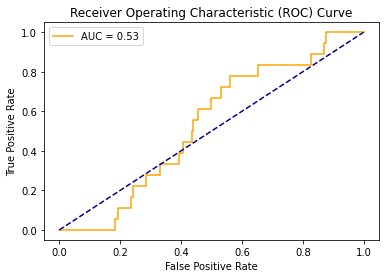

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X_st)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X_st_resampled)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.50      0.66      1782
     Anomaly       0.01      0.61      0.02        18

    accuracy                           0.50      1800
   macro avg       0.50      0.55      0.34      1800
weighted avg       0.98      0.50      0.66      1800


 Matthews Correlation Coefficient 0.021776155384989924

 f1-score 0.023835319609967497

 Balanced Accuracy 0.5547138047138047


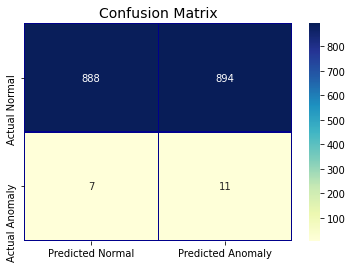

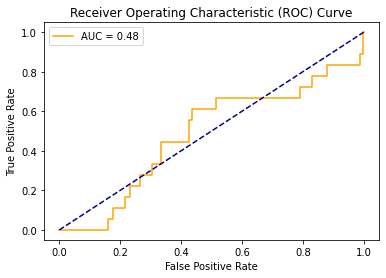

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X_st)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.78      0.88      1782
     Anomaly       0.04      0.94      0.08        18

    accuracy                           0.78      1800
   macro avg       0.52      0.86      0.48      1800
weighted avg       0.99      0.78      0.87      1800


 IForest  Confusion Matrix: 
 [[1387  395]
 [   1   17]]

 IForest Matthews Correlation Coefficient 0.17118074992710705

 IForest f1-score 0.07906976744186046


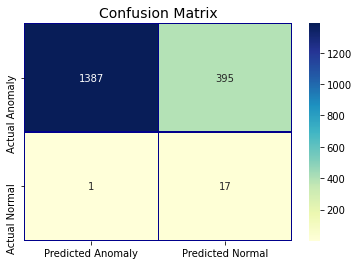

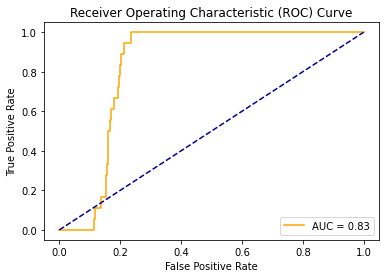

In [ ]:
#Not standardized
#Not Oversampled
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

# BM_941 : least clustered

In [ ]:
#Train-test Split
train_X, test_X, train_y, test_y = train_test_split(skin_941, 4200, 1800, 42)

In [ ]:
#Standardization
scaler = RobustScaler()
train_X_st = scaler.fit_transform(train_X)
test_X_st = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
train_X_st_resampled, train_y_st_resampled= ADASYN(ratio = 'minority').fit_sample(train_X_st, train_y_st)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.009523809523809525
Percentage Test Set Contamination:      0.011111111111111112


## IForest

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 100, max_samples = 1024, contamination = 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.8893, precision @ rank n:0.0

On Test Data:
IForest ROC:0.9049, precision @ rank n:0.0
0.4

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.90      0.94      1780
     Anomaly       0.04      0.40      0.08        20

    accuracy                           0.90      1800
   macro avg       0.52      0.65      0.51      1800
weighted avg       0.98      0.90      0.94      1800


 IForest Matthews Correlation Coefficient 0.10464024011839289

 IForest f1-score 0.07881773399014778

 IForest Balanced Accuracy 0.6508426966292136


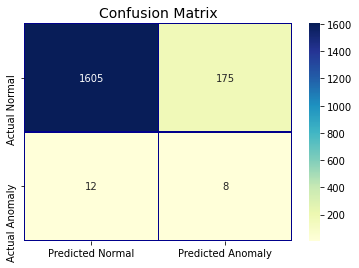

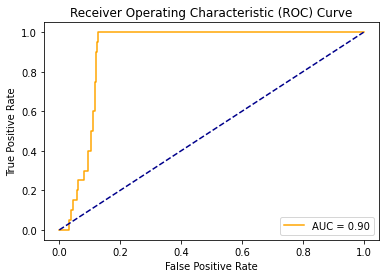

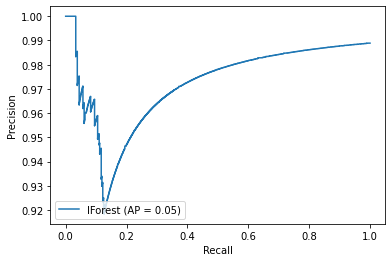

In [ ]:
#Not oversampled
#Not standardized
get_prediction(IForest(n_estimators = 50, max_samples = 2048, contamination = 0.1), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.88      0.94      1780
     Anomaly       0.08      0.90      0.15        20

    accuracy                           0.88      1800
   macro avg       0.54      0.89      0.54      1800
weighted avg       0.99      0.88      0.93      1800


 SciForest  Confusion Matrix: 
 [[1571  209]
 [   2   18]]

 SciForest Matthews Correlation Coefficient 0.24710345809763315

 SciForest f1-score 0.145748987854251


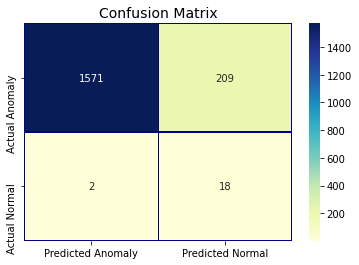

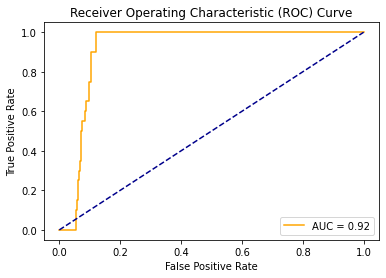

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 75, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.263, precision @ rank n:0.3689

On Test Data:
OCSVM ROC:0.0346, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.98      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.010948379364363325

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.49466292134831463


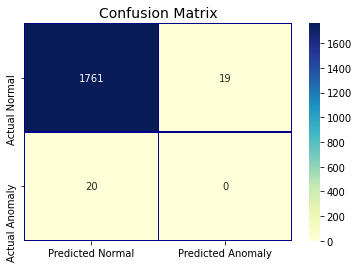

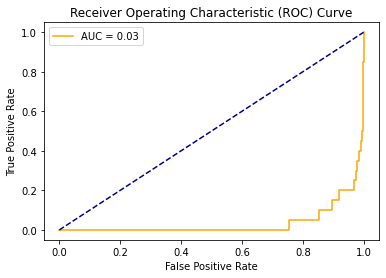

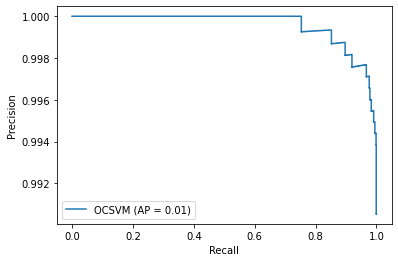

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.8985, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.6951, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.98      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.007514125744851899

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.4974719101123595


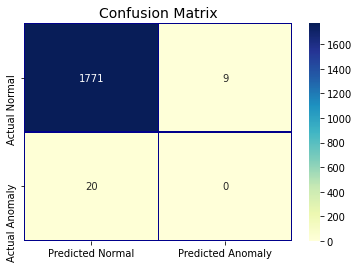

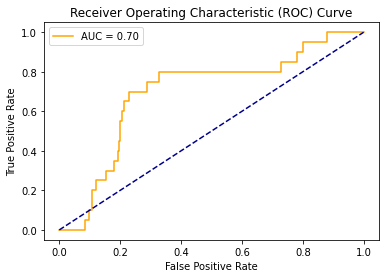

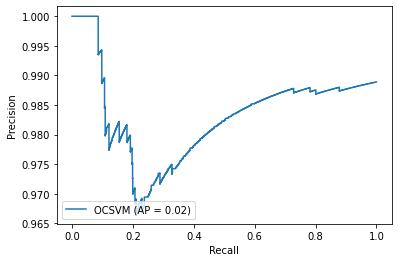

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st, test_X_st, train_y_st, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.352, precision @ rank n:0.3923

On Test Data:
LOF ROC:0.795, precision @ rank n:0.1
0.7

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.83      0.90      1780
     Anomaly       0.04      0.70      0.08        20

    accuracy                           0.83      1800
   macro avg       0.52      0.76      0.49      1800
weighted avg       0.99      0.83      0.90      1800


 LOF Matthews Correlation Coefficient 0.1447861444834275

 LOF f1-score 0.08235294117647059

 LOF Balanced Accuracy 0.7640449438202247


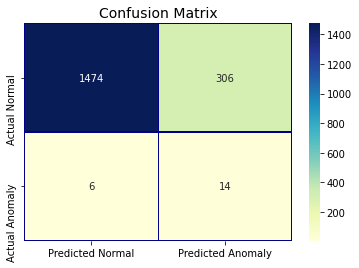

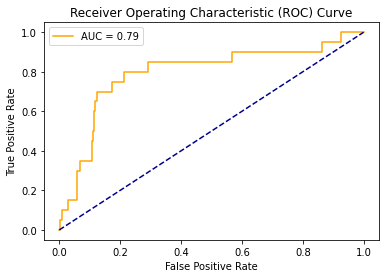

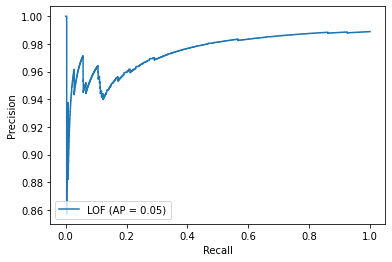

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.547, precision @ rank n:0.0

On Test Data:
LOF ROC:0.5134, precision @ rank n:0.0
0.05

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.85      0.91      1780
     Anomaly       0.00      0.05      0.01        20

    accuracy                           0.84      1800
   macro avg       0.50      0.45      0.46      1800
weighted avg       0.98      0.84      0.90      1800


 LOF Matthews Correlation Coefficient -0.028963875610808123

 LOF f1-score 0.007042253521126762

 LOF Balanced Accuracy 0.451123595505618


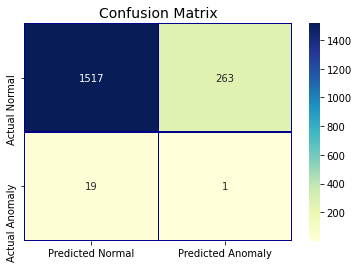

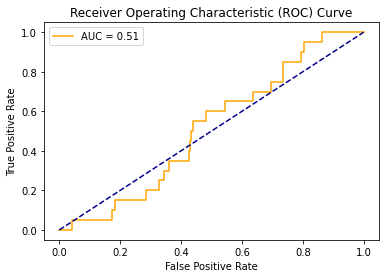

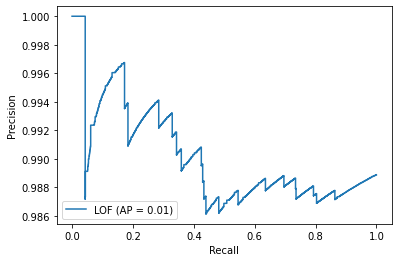

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st, test_X_st, train_y_st, test_y, 'LOF')

## CBLOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 30, alpha= 0.9, beta= 20, random_state=42), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9578, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.9015, precision @ rank n:0.0
0.2

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.94      0.97      1780
     Anomaly       0.04      0.20      0.06        20

    accuracy                           0.93      1800
   macro avg       0.51      0.57      0.51      1800
weighted avg       0.98      0.93      0.96      1800


 CBLOF Matthews Correlation Coefficient 0.06248754756816555

 CBLOF f1-score 0.0625

 CBLOF Balanced Accuracy 0.5707865168539326


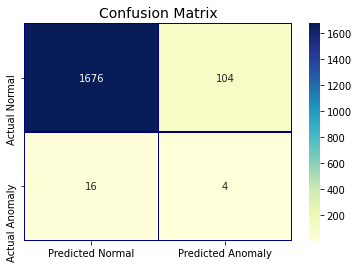

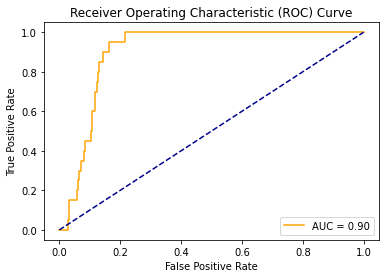

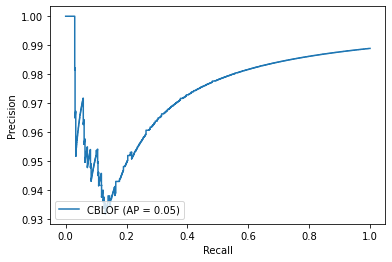

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 30, alpha= 0.9, beta= 25, random_state=42), 
               train_X_st, test_X_st, train_y_st, test_y, 'CBLOF')

## KNN

---



In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.9378, precision @ rank n:0.0

On Test Data:
KNN ROC:0.8257, precision @ rank n:0.0
0.65

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.81      0.89      1780
     Anomaly       0.04      0.65      0.07        20

    accuracy                           0.81      1800
   macro avg       0.52      0.73      0.48      1800
weighted avg       0.98      0.81      0.88      1800


 KNN Matthews Correlation Coefficient 0.12061866164687911

 KNN f1-score 0.06933333333333334

 KNN Balanced Accuracy 0.728932584269663


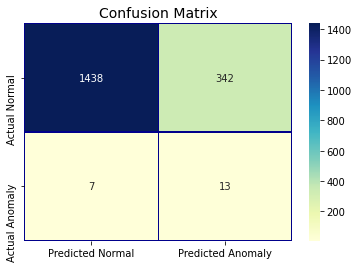

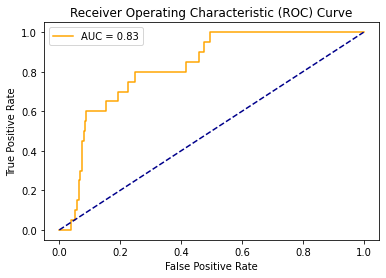

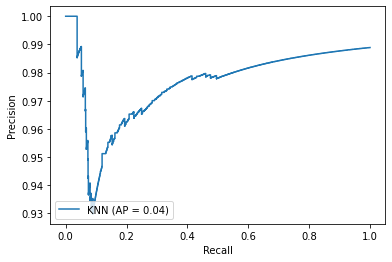

In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.1), 
               train_X_st, test_X_st, train_y_st, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X_st_resampled)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.94      0.96      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.93      1800
   macro avg       0.49      0.47      0.48      1800
weighted avg       0.98      0.93      0.95      1800


 Matthews Correlation Coefficient -0.02611455849637379

 f1-score 0.0

 Balanced Accuracy 0.47106741573033706


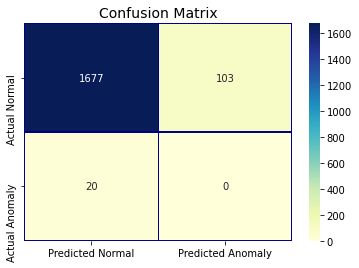

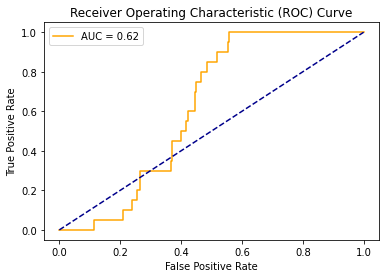

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X_st)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X_st)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.97      1800


 Matthews Correlation Coefficient -0.014260634711480922

 f1-score 0.0

 Balanced Accuracy 0.4910112359550562


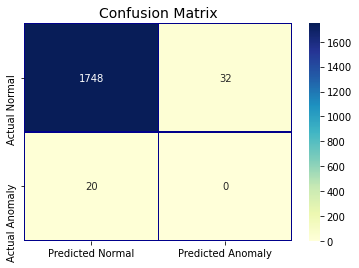

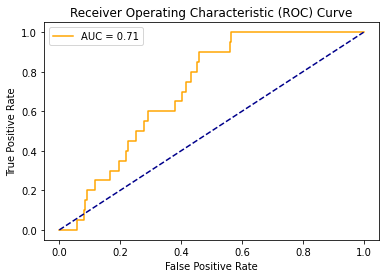

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X_st)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.77      0.87      1780
     Anomaly       0.03      0.65      0.06        20

    accuracy                           0.77      1800
   macro avg       0.51      0.71      0.46      1800
weighted avg       0.98      0.77      0.86      1800


 IForest  Confusion Matrix: 
 [[1365  415]
 [   7   13]]

 IForest Matthews Correlation Coefficient 0.10263842090008407

 IForest f1-score 0.05803571428571428


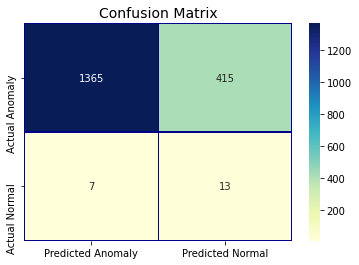

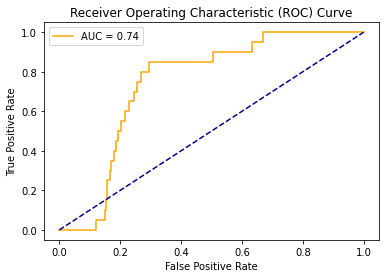

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.93      0.96      1780
     Anomaly       0.01      0.05      0.01        20

    accuracy                           0.92      1800
   macro avg       0.50      0.49      0.49      1800
weighted avg       0.98      0.92      0.95      1800


 SciForest  Confusion Matrix: 
 [[1656  124]
 [  19    1]]

 SciForest Matthews Correlation Coefficient -0.008107941916401374

 SciForest f1-score 0.013793103448275862


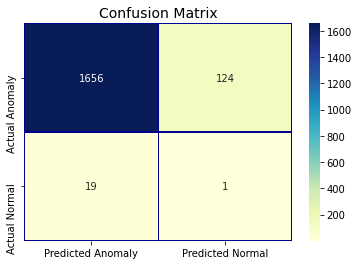

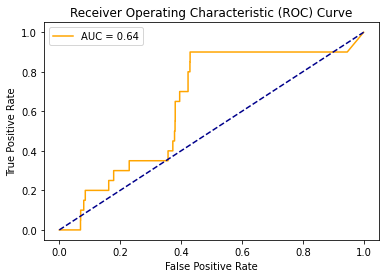

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

# BM_942 : most clustered

In [ ]:
#Train-test split
train_X, test_X, train_y, test_y = train_test_split(skin_942, 4200, 1800, 42)

In [ ]:
#Standardization
scaler = RobustScaler()
train_X_st = scaler.fit_transform(train_X)
test_X_st = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
train_X_st_resampled, train_y_st_resampled= ADASYN(ratio = 'minority').fit_sample(train_X_st, train_y_st)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.009523809523809525
Percentage Test Set Contamination:      0.011111111111111112


## IForest

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 100, max_samples = 1024, contamination = 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.8948, precision @ rank n:0.0

On Test Data:
IForest ROC:0.8864, precision @ rank n:0.0
0.4

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.89      0.94      1780
     Anomaly       0.04      0.40      0.07        20

    accuracy                           0.88      1800
   macro avg       0.52      0.64      0.50      1800
weighted avg       0.98      0.88      0.93      1800


 IForest Matthews Correlation Coefficient 0.09393288558914388

 IForest f1-score 0.06986899563318777

 IForest Balanced Accuracy 0.6435393258426967


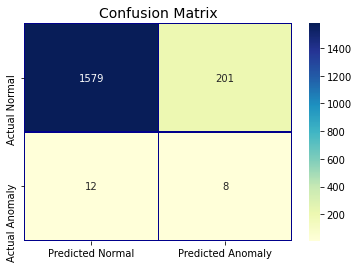

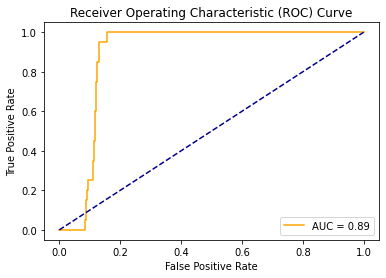

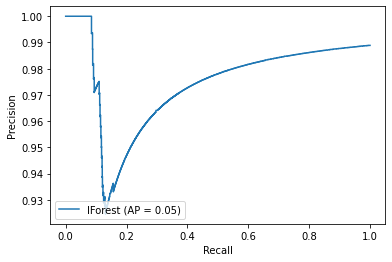

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 2048, contamination = 0.1), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.85      0.92      1780
     Anomaly       0.07      1.00      0.13        20

    accuracy                           0.85      1800
   macro avg       0.53      0.93      0.52      1800
weighted avg       0.99      0.85      0.91      1800


 SciForest  Confusion Matrix: 
 [[1513  267]
 [   0   20]]

 SciForest Matthews Correlation Coefficient 0.24337922975749576

 SciForest f1-score 0.1302931596091205


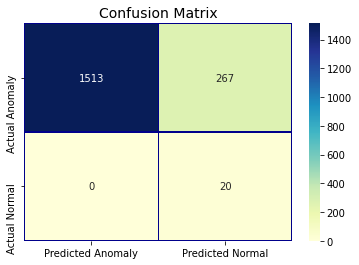

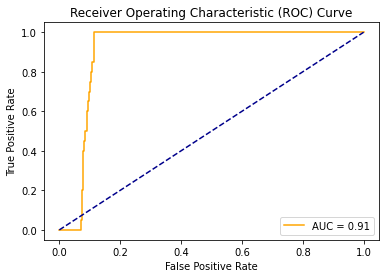

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 85, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.2231, precision @ rank n:0.3234

On Test Data:
OCSVM ROC:0.0195, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.98      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.011516663299185671

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.4941011235955056


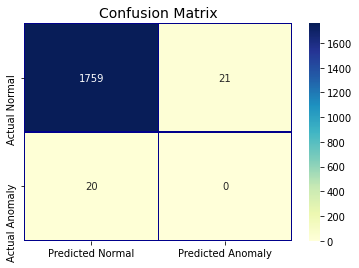

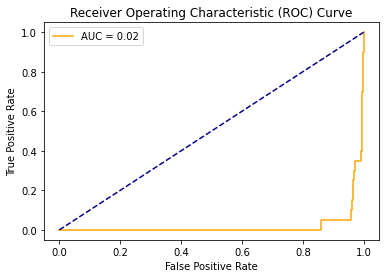

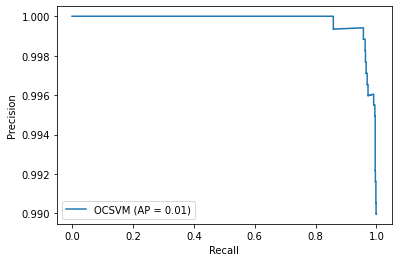

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.8964, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.7095, precision @ rank n:0.0
0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.98      0.98      1800


 OCSVM Matthews Correlation Coefficient -0.007922796137594092

 OCSVM f1-score 0.0

 OCSVM Balanced Accuracy 0.49719101123595505


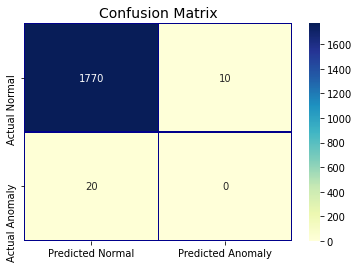

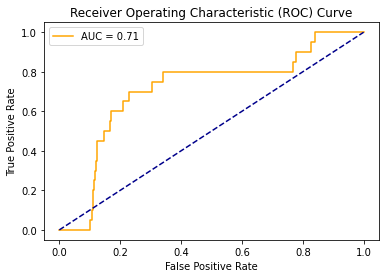

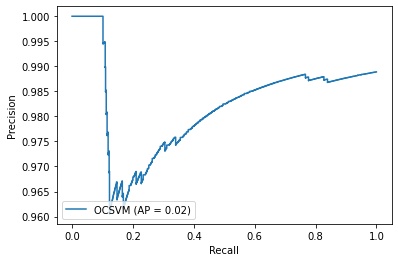

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X_st, test_X_st, train_y_st, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.3742, precision @ rank n:0.4249

On Test Data:
LOF ROC:0.7729, precision @ rank n:0.0
0.6

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.80      0.89      1780
     Anomaly       0.03      0.60      0.06        20

    accuracy                           0.80      1800
   macro avg       0.51      0.70      0.47      1800
weighted avg       0.98      0.80      0.88      1800


 LOF Matthews Correlation Coefficient 0.10421695964553597

 LOF f1-score 0.062015503875968984

 LOF Balanced Accuracy 0.7002808988764044


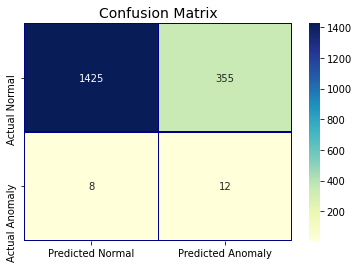

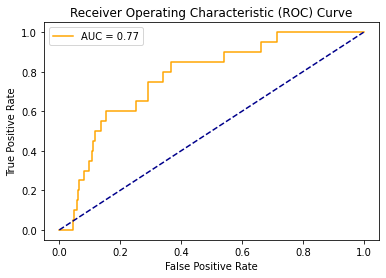

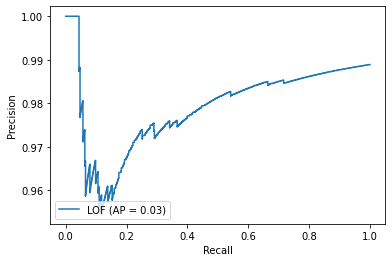

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=100, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.4833, precision @ rank n:0.0

On Test Data:
LOF ROC:0.578, precision @ rank n:0.0
0.05

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.90      0.94      1780
     Anomaly       0.01      0.05      0.01        20

    accuracy                           0.89      1800
   macro avg       0.50      0.47      0.48      1800
weighted avg       0.98      0.89      0.93      1800


 LOF Matthews Correlation Coefficient -0.017970819055721093

 LOF f1-score 0.009900990099009903

 LOF Balanced Accuracy 0.47415730337078654


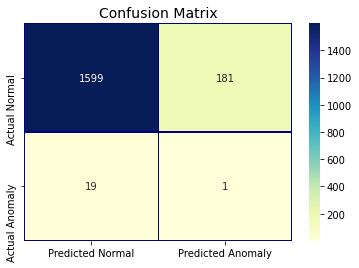

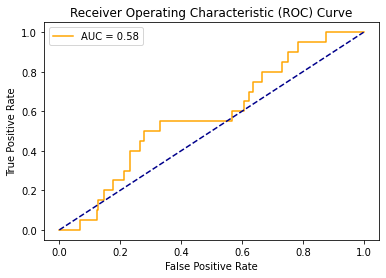

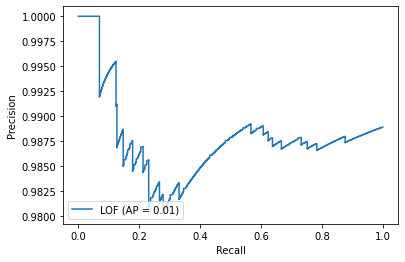

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=30, contamination= 0.1, algorithm='auto', metric = 'cosine'), 
               train_X_st, test_X_st, train_y_st, test_y, 'LOF')

## CBLOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 30, alpha= 0.9, beta= 20, random_state=42), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9403, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.9365, precision @ rank n:0.0
0.75

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.92      0.95      1780
     Anomaly       0.09      0.75      0.16        20

    accuracy                           0.91      1800
   macro avg       0.54      0.83      0.56      1800
weighted avg       0.99      0.91      0.95      1800


 CBLOF Matthews Correlation Coefficient 0.24097757459107286

 CBLOF f1-score 0.16129032258064516

 CBLOF Balanced Accuracy 0.8325842696629213


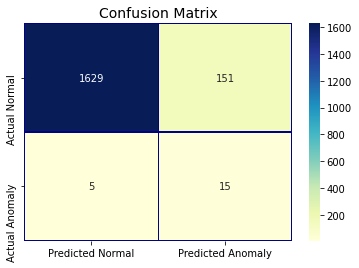

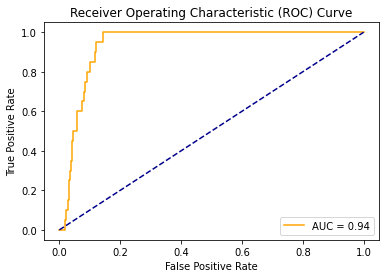

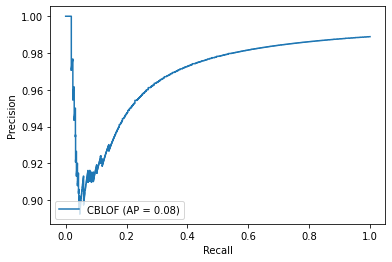

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.07, n_clusters= 30, alpha= 0.9, beta= 25, random_state=42), 
               train_X_st, test_X_st, train_y_st, test_y, 'CBLOF')

## KNN

---



In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.941, precision @ rank n:0.0

On Test Data:
KNN ROC:0.9072, precision @ rank n:0.0
0.95

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.78      0.87      1780
     Anomaly       0.05      0.95      0.09        20

    accuracy                           0.78      1800
   macro avg       0.52      0.86      0.48      1800
weighted avg       0.99      0.78      0.87      1800


 KNN Matthews Correlation Coefficient 0.18047805585219878

 KNN f1-score 0.08695652173913043

 KNN Balanced Accuracy 0.8632022471910112


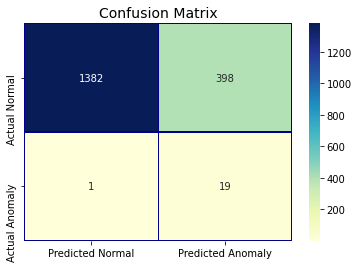

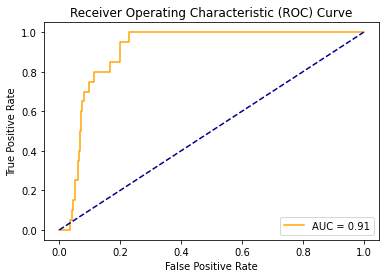

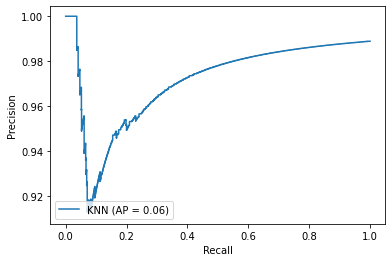

In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.1), 
               train_X_st, test_X_st, train_y_st, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

On Training Data:
ABOD ROC:0.0512, precision @ rank n:0.1333

On Test Data:
ABOD ROC:0.6871, precision @ rank n:0.0
0.1

 ABOD  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.92      0.95      1780
     Anomaly       0.01      0.10      0.02        20

    accuracy                           0.91      1800
   macro avg       0.50      0.51      0.49      1800
weighted avg       0.98      0.91      0.94      1800


 ABOD Matthews Correlation Coefficient 0.006160333060921982

 ABOD f1-score 0.023391812865497075

 ABOD Balanced Accuracy 0.5081460674157303


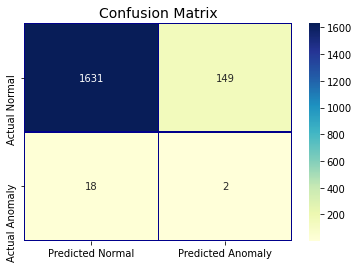

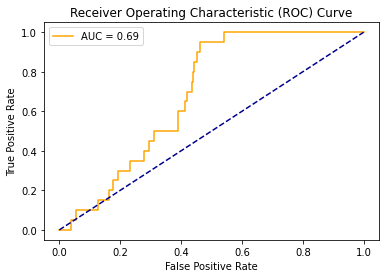

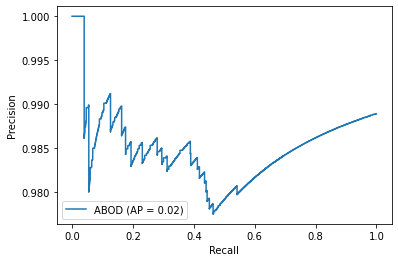

In [ ]:
get_prediction(ABOD(contamination=0.01, n_neighbors=210, method= 'fast'), 
               train_X_st_resampled, test_X_st, train_y_st_resampled, test_y, 'ABOD')

In [ ]:
# train ABOD detector
clf_name = 'ABOD'
clf = ABOD(contamination=0.01, n_neighbors=210, method= 'fast').fit(train_X)


  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      1780
     Anomaly       0.00      0.00      0.00        20

    accuracy                           0.97      1800
   macro avg       0.49      0.49      0.49      1800
weighted avg       0.98      0.97      0.97      1800


 Matthews Correlation Coefficient -0.013799996964001

 f1-score 0.0

 Balanced Accuracy 0.49157303370786515


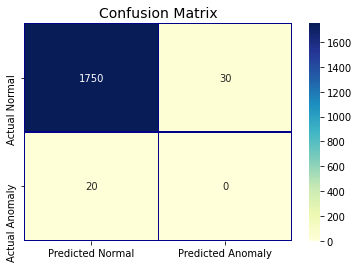

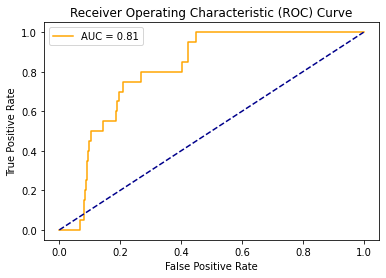

In [ ]:
# get the prediction on the test data
pred = clf.predict(test_X)  # outlier labels (0 or 1)

print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

IForest-Isotree

---



In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---



In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')